# Assignment 8, Question #3: San Francisco Crime Classification
We will submit two tree-based models (a Random Forest and a Gradient Boosting model) and one Support Vector Machine (SVM).
## Exploratory Data Analysis, Data Preprocessing, and Feature Engineering
The dataset provided contains historical crime data from 2003 to 2015. It contains Dates, Category (Target variable), Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y.  
We need to convert categorical variables into numerical, extract meaningful features from the 'Dates' column, and scale our data appropriately.  
From the 'Dates' column, we can extract the year, month, day, and hour of the day. These temporal features are likely to have a strong influence on the type of crime committed.  
For 'Address,' we will create a binary feature indicating if the crime occurred at an intersection (containing 'of') or a block.  
The 'DayOfWeek' and 'PdDistrict' columns are categorical. We will use one-hot encoding to convert these into numerical features that our models can understand.  
Also, all features must be on a similar scale for the SVM model. We will use a standard scaler to achieve this.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

train_df = pd.read_csv('/kaggle/input/sfcrime/train.csv', parse_dates=['Dates'])
test_df = pd.read_csv('/kaggle/input/sfcrime/test.csv', parse_dates=['Dates'])

def feature_engineer(df):
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['Hour'] = df['Dates'].dt.hour
    df['IsIntersection'] = df['Address'].apply(lambda x: 1 if ' of ' in x else 0)
    return df

train_df = feature_engineer(train_df)
test_df = feature_engineer(test_df)

dups = train_df.duplicated().sum()
print(f"Number of duplicates: {dups}")
train_df = train_df.drop_duplicates()

# Encoding the target variable
le = LabelEncoder()
train_df['Category_Encoded'] = le.fit_transform(train_df['Category'])

# One-Hot Encoding categorical features
categorical_features = ['DayOfWeek', 'PdDistrict']
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

# Alignment to create submissions
train_labels = train_df['Category_Encoded']
train_ids = train_df.index
test_ids = test_df['Id']

# Keep necessary columns
train_df = train_df.drop(columns=['Dates', 'Category', 'Descript', 'Resolution', 'Address', 'Category_Encoded'])
test_df = test_df.drop(columns=['Dates', 'Address', 'Id'])

train_cols = train_df.columns
test_cols = test_df.columns

# Scaling  and splitting
scaler = StandardScaler()
X = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)
X_train, X_val, y_train, y_val = train_test_split(X, train_labels, test_size=0.2, random_state=42)

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Number of duplicates: 2323


## Model 1: Random Forest Classifier

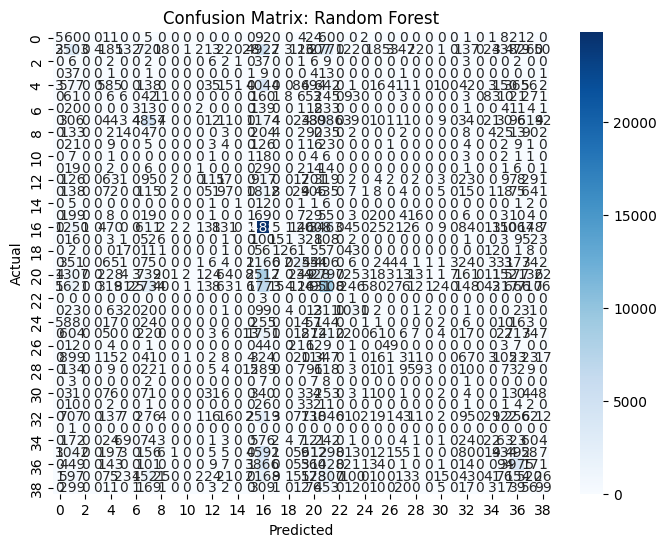

Random Forest Accuracy: 0.3176
Random Forest Feature Importances:
                  Feature  Importance
1                       Y    0.191800
0                       X    0.186678
4                     Day    0.139342
5                    Hour    0.130004
3                   Month    0.112148
2                    Year    0.104124
6          IsIntersection    0.020471
10     DayOfWeek_Thursday    0.015229
7        DayOfWeek_Monday    0.014960
11      DayOfWeek_Tuesday    0.014781
12    DayOfWeek_Wednesday    0.014468
8      DayOfWeek_Saturday    0.013081
9        DayOfWeek_Sunday    0.012458
21  PdDistrict_TENDERLOIN    0.008901
19    PdDistrict_SOUTHERN    0.004531
15     PdDistrict_MISSION    0.003377
16    PdDistrict_NORTHERN    0.003142
13     PdDistrict_CENTRAL    0.003063
14   PdDistrict_INGLESIDE    0.002848
17        PdDistrict_PARK    0.001622
20     PdDistrict_TARAVAL    0.001508
18    PdDistrict_RICHMOND    0.001463
Random Forest submission file created: 'submission_rf.csv'


In [2]:
#param_grid_rf = {
#    'n_estimators': [10, 100],
#    'max_depth': [10, 20, None],
#    'min_samples_split': [2, 10]
#}
#rf_model = RandomForestClassifier(random_state=55, n_jobs=-1)
# Scikit-learn Random Forest with GridSearchCV causes memory leak and program crash (on both kaggle and local computer). dataset is too big.
#grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
#grid_search_rf.fit(X_train, y_train)
#rf_model = grid_search_rf.best_estimator_
rf_model = RandomForestClassifier(n_estimators=400, min_samples_split=10, random_state=55, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
plot_conf_matrix(y_val, y_pred_rf, "Random Forest")
accscore = accuracy_score(y_val , y_pred_rf)
#print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
print(f"Random Forest Accuracy: {accscore:.4f}")

feature_importance_df = pd.DataFrame({
    'Feature': train_cols,
    'Importance': rf_model.feature_importances_
})
print("Random Forest Feature Importances:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))

rf_test_preds = rf_model.predict_proba(X_test)
rf_submission_df = pd.DataFrame(rf_test_preds, columns=le.classes_, index=test_ids)
rf_submission_df.to_csv('submission_rf.csv', index_label='Id')
print("Random Forest submission file created: 'submission_rf.csv'")

Random Forests are non-parametric and do not make strong assumptions about the data distribution or the relationships between features.  
The Random Forest model provides a feature importance score for each feature, which indicates how much that feature contributed to the model's predictive power. By examining these scores, we can identify the most influential factors in determining the crime category: Location(X, Y), Day, Hour, Month, Year.  
## Model 2: Gradient Boosting
We selected XGBoost instead of GradientBoostingClassifier for various reasons: XGBoost is faster, uses parallel processing, and offers cache optimization.  It has built-in L1 and L2 regularization and handles missing values internally.

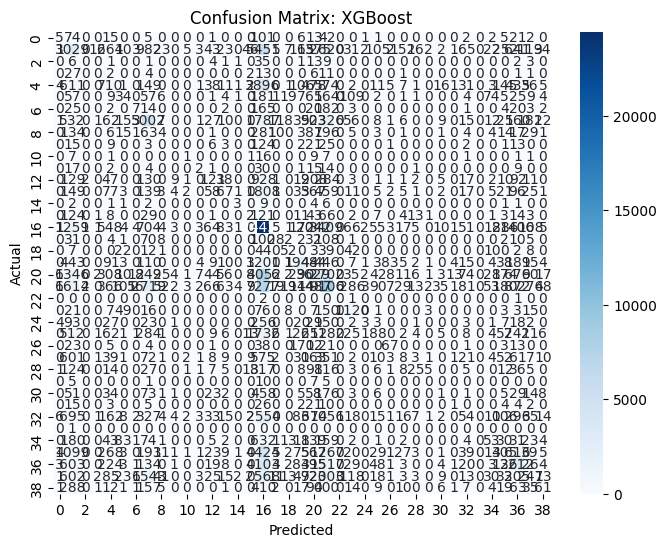

XGBoost Accuracy: 0.3056
XGBoost Feature Importances:
                  Feature  Importance
21  PdDistrict_TENDERLOIN    0.247718
6          IsIntersection    0.163287
19    PdDistrict_SOUTHERN    0.055296
15     PdDistrict_MISSION    0.050070
17        PdDistrict_PARK    0.044594
1                       Y    0.039628
0                       X    0.039441
16    PdDistrict_NORTHERN    0.030841
13     PdDistrict_CENTRAL    0.030468
5                    Hour    0.030366
18    PdDistrict_RICHMOND    0.030313
2                    Year    0.028767
14   PdDistrict_INGLESIDE    0.027467
20     PdDistrict_TARAVAL    0.022949
9        DayOfWeek_Sunday    0.021669
8      DayOfWeek_Saturday    0.021552
3                   Month    0.019902
4                     Day    0.019834
7        DayOfWeek_Monday    0.019108
11      DayOfWeek_Tuesday    0.019066
10     DayOfWeek_Thursday    0.018844
12    DayOfWeek_Wednesday    0.018819
XGBoost submission file created: 'submission_xgb.csv'


In [3]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', n_estimators=200, learning_rate=0.1, max_depth=10, random_state=55, n_jobs=-1)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
plot_conf_matrix(y_val, y_pred_xgb, "XGBoost")
accscore = accuracy_score(y_val , y_pred_xgb)
#print(f"Best XGBoost Parameters: {grid_search_rf.best_params_}")
print(f"XGBoost Accuracy: {accscore:.4f}")

feature_importance_df = pd.DataFrame({
    'Feature': train_cols,
    'Importance': xgb_model.feature_importances_
})
print("XGBoost Feature Importances:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))

xgb_test_preds = rf_model.predict_proba(X_test)
xgb_submission_df = pd.DataFrame(xgb_test_preds, columns=le.classes_, index=test_ids)
xgb_submission_df.to_csv('submission_xgb.csv', index_label='Id')
print("XGBoost submission file created: 'submission_xgb.csv'")

Like Random Forests, Gradient Boosting is a non-parametric method and does not assume a specific distribution for the data.  
Like the Random Forest, we can extract feature importances from the XFBoost model. This allows us to rank the features by their predictive power again. We see similar features, but District and Intersection seem more critical here.
## Model 3: SVM

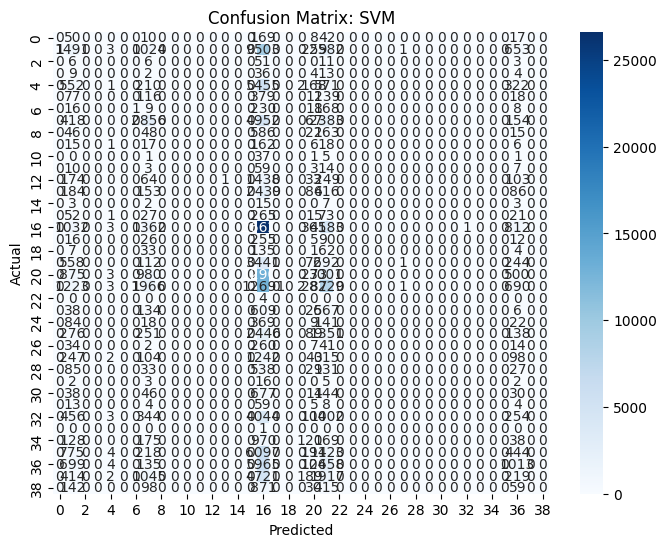

SVM Accuracy: 0.2312
SVM submission file created: 'submission_svm.csv'


In [4]:
# For large datasets consider using LinearSVC or SGDClassifier instead: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Use LinearSVC, which is much faster for this dataset
# Wrap it in CalibratedClassifierCV to get probabilities
svm_model = LinearSVC(random_state=55, C=0.1, dual=False)
calibrated_svc = CalibratedClassifierCV(svm_model, cv=3, method='isotonic') # isotonic often works well for large datasets
calibrated_svc.fit(X_train, y_train)
#svm_model.fit(X_train, y_train)

y_pred_svm = calibrated_svc.predict(X_val)
#y_pred_svm = svm_model.predict(X_val)
plot_conf_matrix(y_val, y_pred_svm, "SVM")
accscore = accuracy_score(y_val , y_pred_svm)
#print(f"Best SVM Parameters: {grid_search_rf.best_params_}")
print(f"SVM Accuracy: {accscore:.4f}")

#Feature importance not available for LinearSVC - we can use _coef, sort and plot
#feature_importance_df = pd.DataFrame({
#    'Feature': train_cols,
#    'Importance': svm_model.feature_importances_
#})
#print("SVM Feature Importances:")
#print(feature_importance_df.sort_values(by='Importance', ascending=False))

svm_test_preds = calibrated_svc.predict_proba(X_test)
#svm_test_preds = svm_model.predict_proba(X_test)
svm_submission_df = pd.DataFrame(svm_test_preds, columns=le.classes_, index=test_ids)
svm_submission_df.to_csv('submission_svm.csv', index_label='Id')
print("SVM submission file created: 'submission_svm.csv'")

SVMs are highly sensitive to the scale of the features. As done above, it is crucial to scale the data before training the model.  
Interpreting an SVM with a non-linear kernel is more complex than interpreting tree-based models. We cannot get simple feature importance scores.